# Installation Instructions

To use this code, you will need:
* numpy
* scipy
* matplotlib
* functools
* ipython
* psydot

All packages should be installable via pip.

There are two files of functions. File optimal_transport_V2.py contains the code to run semi-discrete optimal transport. For $d=2$, pysdot is doing the heavy lifting of laguerre cell computation and integration. The most important function in that file is called optimal_transport. It runs optimal_transport used Hessian informed steps. File mass_update_V2.py contains the code to perform the weight optimization. The most important function in that file called run_mass_update. It runs the weight optimization using alternating ascent and gradient descent steps.

There is documentation about the most important functions in these two files that explains what the paramters are, and what the code is doing.

Function optimal_transport and function run_mass_update **now support $d=1$ and $d=2$ calculations**. For $d=2$ calculations, only histogram source densities are allowed. For $d=2$ calculations, you need to create the histogram first, and feed it into your desired function as the $twoDimDensity$ argument (you'll see some examples of this below).

Lets go through a couple of quick examples. Before we do, here is a quick cautions about this code:

### Caution  1

If you would like to see examples where the code will throw warnings and not provide output, build examples where there is data outside of the support of the probability density. More info is provided about this in example 7 of this tutorial. The other easy way to make the code do unpredictable things is to choose a massive value for $\lambda$ in mass_update. More information on that in example 5.

### Caution 2

In the $d=2$ case, pysdot hides a couple of key calculations -- like power diagram and integral computation -- in C packages. And those C packages have zero documentation. So if you just want to follow the logic of how SDOT works, then follow the $d=1$ logic.

### Caution 3

I have just written this code in the last week or so. If you discover new issues, let me know or fix it if you feel so inclined :)

## Example 1: Making 2 dimensional source densities

Right now, the code supports making histogram source densities only. The function make_product_beta_density histogramizes the $beta(\alpha_1,\beta_1) \times beta(\alpha_2,\beta_2)$ distribution, with $frequency$ number of splits per axis. Here is an example of how to use it.

In [ ]:
import optimal_transport_V2 as ot
import mass_update_V2 as mu
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

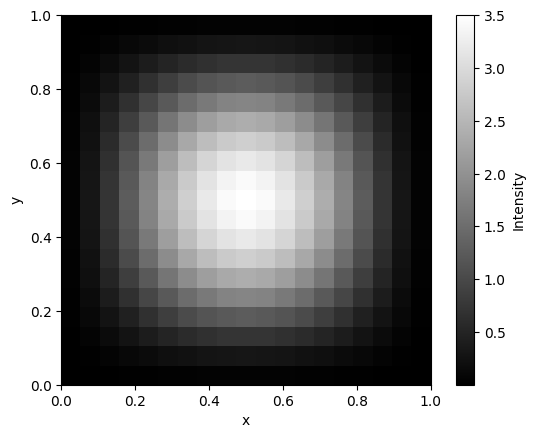

In [52]:
alpha1 = 3
beta1 = 3
alpha2 =3
beta2 = 3
frequency = 20
dens = ot.make_product_beta_density(alpha1,beta1,alpha2,beta2,frequency,display=True)

If you want a histogram source density that is not based on a product of beta distributions, then you can supply the mass_image_SI function with your own histogram. For example, suppose we want to create a histogram with 4 cells, where for $x \in [0,1/2], y \in [0,1/2]$ the probability is $.1$, for $x \in [0,1/2], y \in [1/2,1]$, the probabilty is $.3$, for $x \in [1/2,1], y \in [0,1/2]$ the probability is $.2$. And for the last cell the probability is $.4$. Here is how to do that.

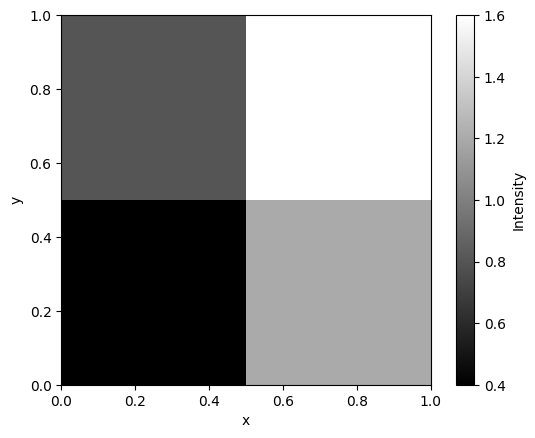

In [53]:
img = 4*np.array([[.1,.3],[.2,.4]]) #4 is number of bins. Multiplied here to make this a proper density
dens = ot.make_image_SI(img,display=True)

## Example 2: Computing $W_2^2$ (a $d=2$ example)

This example shows how to compute $W_2^2$ between a source histogram density and a discrete measure. The syntax of interest here is the function call to computeW2_squared. The first argument is the data, the second are the masses. The third argument, being set to true, plots the power diagram associated with the solution.

In this loop, we are generating more and more data points from the $Beta(3,3) \times Beta(3,3)$, and each time computing the $W_2^2$ between the target density and the empirical measure of the random data.

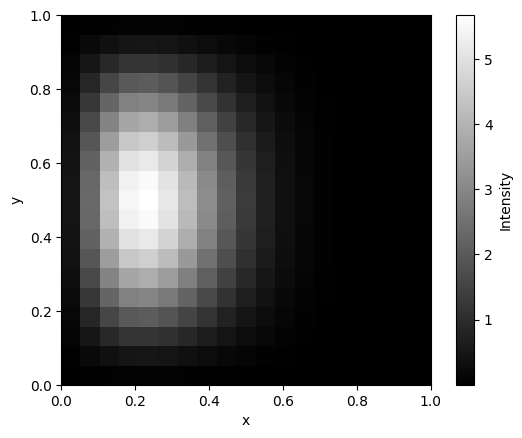

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [54]:
alpha1 = 3
beta1 = 8
alpha2 = 3
beta2 = 3
frequency = 20
dens = ot.make_product_beta_density(alpha1,beta1,alpha2,beta2,frequency,display=True)

Ns = [50,100,150,200]
w2Vals = np.zeros(len(Ns))
j=0
for n in Ns:
    dat = np.column_stack((
        beta.rvs(alpha1,beta1,size=n),
        beta.rvs(alpha2,beta2,size=n)
    ))
    w2Val = ot.computeW2_squared(dat,np.ones(n)/n,dens,plotPowerDiagram=True,dimension=2)
    w2Vals[j] = w2Val
    j=j+1

## Important Note
The density plotter and the power-diagram plotter differ in the following way. The density plotter views the y axis as $0 = low$ and $1 = high$. The power-diagram plotter reverses this, plotting the y axis as $1 = low$ and $0 = high$. I can fix this later. It is not something that needs to be accounted for in the above plots because the y distribution is symmetric, but keep this in mind.

## Example 3: Computing $W_2^2$ (a $d=1$ example)

You use the SAME function, computeW2_squared, for $d=1$ and $d=2$. What differs is in how you provide the source density to the function

When $d=1$, you need to do the following: 
* set dimension=1
* set twoDimDensity=None
* provide the distr, oneDimBounds, and optional_arguments

distr is the name of the source density. Currenlty "beta" and "normal" are implemented. oneDimBounds is a two dimensional list consisting of the lower bound of the support of the density as the first entry, and the upper bound of the support as the second entry. optional_arguments is a list of the parameters of distr. If distr = "beta", set optional_arguments=[$\alpha$,$\beta$]. If distr = "normal", set optional_arguments = [$\mu$,$\sigma$].

Here are a couple of examples:

### Example 3.1: Uniform empirical measure against $Beta(.5,.5)$

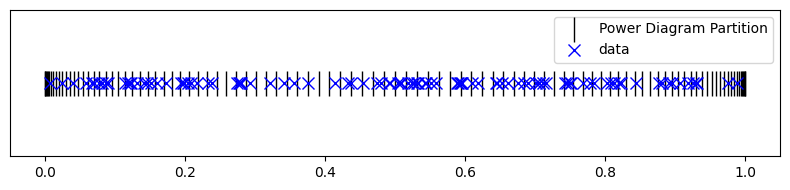

The W_2^2 is 0.007703966250487795


In [55]:
alpha = .5
n=100
dat = np.random.uniform(0,1,n)
z = ot.computeW2_squared(dat,np.ones(n)/n,None,plotPowerDiagram=True,
                             dimension=1,distr="beta",oneDimBounds=[0,1],optional_arguments=[alpha,alpha],illConditionThresh=10e20)
print("The W_2^2 is "+str(z))

Note the following:
* The power diagram is displayed. Since the $Beta(.5,.5)$ has highest mass at the edges and the discrete distribution is uniform, the cells of the power diagram are smaller at the edges than in the middle.
* Note that I set the illConditionThresh=10e20 in this example. (I will at some point put a detailed description of what this means in the tutorial. For now, suffice to know that if you ever get the warning that optimal transport has reached an ill-conditioned solution point, then you may want to try to increase illConditionThresh. This method is not fool proof because sometimes the solution is ill-conditioned, but for now it is fine. I recommend setting illConditionThresh=10e5 for $d=2$)

### Example 3.2: Uniform empirical measure against $N(0,1)$

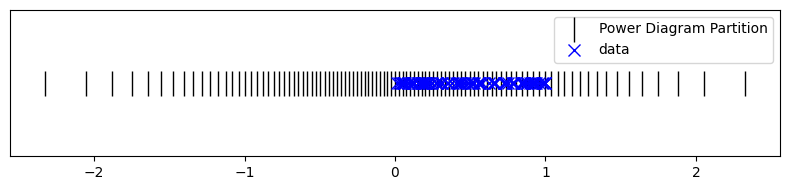

The W_2^2 is 0.7284055441694612


In [56]:
n=100
dat = np.random.uniform(0,1,n)
z = ot.computeW2_squared(dat,np.ones(n)/n,None,plotPowerDiagram=True,
                             dimension=1,distr="normal",oneDimBounds=[-np.inf,np.inf],optional_arguments=[0,1],illConditionThresh=10e15)
print("The W_2^2 is "+str(z))

## Example 4: Running Weight Optimization with Uniform Contamination

In this example, we show how to perform weight optimization when the source density is the uniform distribution, and the $100(1-\alpha)\%$ of the data follows the uniform, and the remaining data is clustered into a corner of the uniform distribution.

We'll show how to do this in both the $d=1$ and $d=2$ cases, starting with $d=1$. Here we'll fix $\alpha = .2$ and $n=100$, and for each $\lambda$ in a collection of $\lambda$ values, generate as set of $n$ data locations, and run weight optimization 10 times. The weights associated with the best value of the objective function for each $\lambda$ will be plotted.

Why do this $10$ times for each $\lambda$? The data is the same and the density is the same, but we will randomely initalize the optimization to a different location each time. This is because the optimization algorithm is only guaranteed to converge to a saddle point, but not nescessarily the best saddle point. 

We use mass_update_repeated_runner in mass_update_V2.py to run the experiment. Mass_update_repeated_runner just repeatedly runs mass update a certain number of times, each time using a different initialization of the weight vector, for a given set of data and a given density. 

Note here, the third parameter to mass update is a vector of concentrations, corresponding to the parameter of the Dirichlet distribution used to generate a random initial weight vector. The fourth parameter, set to None, corresponds to the twoDimDensity argument. The next parameter, called lamMethod (see the documentation in run_mass_update), should always be set to "absolute" for now. The next parameter is a initial learning rate for backtracking (set to $.1$ here).

The number of iterations is 97
The number of iterations is 46
The number of iterations is 80
The number of iterations is 103
The number of iterations is 37
The number of iterations is 37
The number of iterations is 71
The number of iterations is 65
The number of iterations is 69
The number of iterations is 80
The number of iterations is 97
The number of iterations is 59
The number of iterations is 93
The number of iterations is 76
The number of iterations is 48
The number of iterations is 69
The number of iterations is 92
The number of iterations is 102
The number of iterations is 32
The number of iterations is 60
The number of iterations is 105
The number of iterations is 54
The number of iterations is 44
The number of iterations is 41
The number of iterations is 53
The number of iterations is 116
The number of iterations is 96
The number of iterations is 66
The number of iterations is 128
The number of iterations is 73


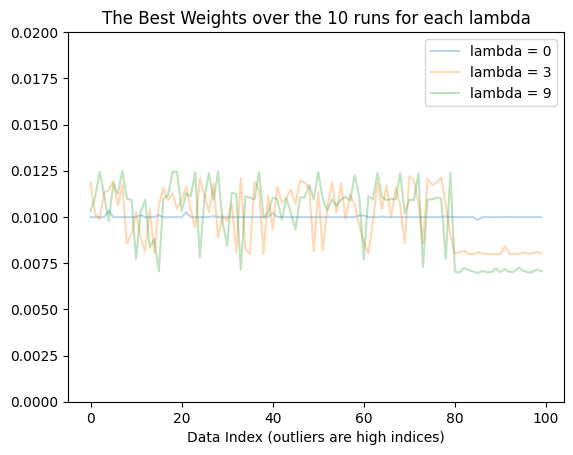

In [57]:
numWeightInit = 10
lams = [0,3,9]
#fig, axes = plt.subplots(len(lams),1,figsize=(4,5))
alpha = .2
N = 100
plt.ylim((0,.05))
for lam in lams:
    N_reg = int(np.floor(N*(1-alpha)))
    N_out = int(np.floor(N*alpha))
    Y = np.random.uniform(0,1,N_reg)
    Y2 = np.random.uniform(.97,1,N_out)
    N = len(Y)+len(Y2)
    Y = np.concatenate((Y,Y2))
    bestWeights,objVals,wassers,klCosts = mu.mass_update_repeated_runner(Y,numWeightInit,np.ones(N),None,"absolute",.1,lam,verbose=True,traceCanvas=None,dimension=1,distr="beta",oneDimBounds=[0,1],optional_arguments=[1,1],illConditionThresh=10e10)
    plt.plot(bestWeights,alpha=0.3,label="lambda = "+str(lam))
    plt.title("The Best Weights over the 10 runs for each lambda")
    plt.xlabel("Data Index (outliers are high indices)")
    plt.ylim((0,.02))
plt.legend()
plt.show()

How do we run this same example idea for $d=2$? By generating bivariate data, and by changing the twoDimDensity argument to the uniform probability distribution. The $\lambdas$ need to be set differently to get interesting looking plots. See the next example for more information on this.

The number of iterations is 32
The number of iterations is 48
The number of iterations is 56
The number of iterations is 36
The number of iterations is 71
The number of iterations is 61
The number of iterations is 49
The number of iterations is 57
The number of iterations is 88
The number of iterations is 93
The number of iterations is 78
The number of iterations is 107
The number of iterations is 55
The number of iterations is 72
The number of iterations is 81
The number of iterations is 68
The number of iterations is 96
The number of iterations is 80
The number of iterations is 44
The number of iterations is 118
The number of iterations is 90
The number of iterations is 51
The number of iterations is 81
The number of iterations is 29
The number of iterations is 38
The number of iterations is 95
The number of iterations is 90
The number of iterations is 70
The number of iterations is 105
The number of iterations is 95


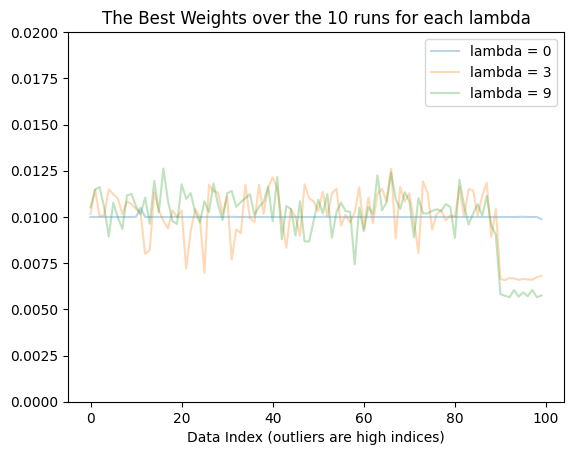

In [58]:
numWeightInit = 10
lams = [0,3,9]
alpha = .1
j=0
N = 100
for lam in lams:
    N_reg = int(np.floor(N*(1-alpha)))
    N_out = int(np.floor(N*alpha))
    Y = np.column_stack((
        np.random.uniform(0,1,N_reg),
        np.random.uniform(0,1,N_reg)
    ))
    Y2 = np.column_stack((
        np.random.uniform(.97,1,N_out),
        np.random.uniform(.97,1,N_out)
    ))
    N = len(Y)+len(Y2)
    Y = np.vstack((Y,Y2))
    bestWeights,objVals,wassers,klCosts = mu.mass_update_repeated_runner(Y,numWeightInit,np.ones(N),ot.make_square(),"absolute",.1,lam,verbose=True,traceCanvas=None,upperLimOnTracePlot=None,dimension=2)
    plt.plot(bestWeights,alpha=0.3,label="lambda = "+str(lam))
    plt.title("The Best Weights over the 10 runs for each lambda")
    plt.xlabel("Data Index (outliers are high indices)")
    plt.ylim((0,.02))

plt.legend()
plt.show()



# Example 5: Determining a Plausible max $\lambda$ value given a source density and a collection of locations

For sake of example, suppose the source density is the uniform distribution on $[0,1]^2$ (call it $\mu$), and the positions of the data are generated according to the rule that $100*\alpha\%$ of the data are generated in a tiny corner of $[0,1]^2$ and the rest of the data is generated uniformily in $[0,1]^2$.

For the data locations $\mathbf{x}_n$, we need to determine the maximum value of $\lambda$ where the weight optimization problem still makes sense (recall each $\lambda$ is associated to an $\epsilon$ and an $\epsilon$ satisfying $\epsilon < \min_{\mathbf{w}} W_2^2(\mu,P(\mathbf{x}_n,\mathbf{w})))$ where $P(\mathbf{x}_n,\mathbf{w})$ is the discrete probability distribution with locations $\mathbf{x}_n$ and weights $\mathbf{w}$ leads to an optimization problem with no valid solution.

We can use the function max_lambda_finder in the mass_update file to explore what the maximum $\lambda$ value might be. The below function, doLambdaExp, allows us to explore various settings of $n$ and $\alpha$, and for each one, generates a single dataset, and then produces visualizations to help us determine what might be a reasonable max lambda value.

doLambdaExp calls max_lambda_finder. Note that max_lambda_finder takes in the data locations, a number of random initializations to perform, and concentration vector for the Dirichlet being used to generate a random initial starting point for each weight optimization, the source density, and a set of $\lambda$ values. For each $\lambda$ value, $numWeightInit$ times, a random initial mass is selected from the Dirichlet with concentration vector concentrationInit. And then weight optimization is run.

max_lambda_finder outputs 4 graphics. Upper left: box plot of the objective function values at the solution for each $\lambda$. Upper right: box plot of the $W_2^2$ at the solution for each $\lambda$. Lower left: box plot of $F(w) = \sum_{w} w_i \log(w_i)$ at the solution for each $\lambda$. Lower right: For each $\lambda$, shows the value of the $W_2^2$ from the run that produced the lowest value of the objective function.

The most useful plots for now are the ones in the right column. When the objective function value starts to rise again (or stops decreasing), we have some heuristic information that the max value of $\lambda$ may have been reached. 

In [59]:
def doLambdaExp(N,alpha,numWeightsInit,weightInitStrategy,lambdas,densType = "unif",optional_arguments = None):
    numUnif = int(np.floor(N*(1-alpha)))
    numOutlier = int(np.floor(N*alpha))
    Y = np.column_stack((
        np.random.uniform(0,1,numUnif),
        np.random.uniform(0,1,numUnif)
    ))
    numNonOutlier = np.shape(Y)[0]
    Y2 = np.column_stack((
        np.random.uniform(.97,1,numOutlier),
        np.random.uniform(.97,1,numOutlier)
    ))
    Y = np.vstack([Y,Y2])
    N = np.shape(Y)[0]
    
    if weightInitStrategy == "unif":
        concentrationInit = np.ones(N)

    if densType == "unif":
        density = ot.make_square()
    mu.max_lambda_finder(Y,numWeightsInit,concentrationInit,density,lambdas,densityString="Uniform.",dataString="Uniform_Contam,alpha="+str(alpha))

Now working on lambda = 0
Now working on lambda = 5
Now working on lambda = 10
Now working on lambda = 15
Now working on lambda = 20
Now working on lambda = 25
Now working on lambda = 30
Now working on lambda = 35
Now working on lambda = 40
Now working on lambda = 45
Now working on lambda = 50
Now working on lambda = 60


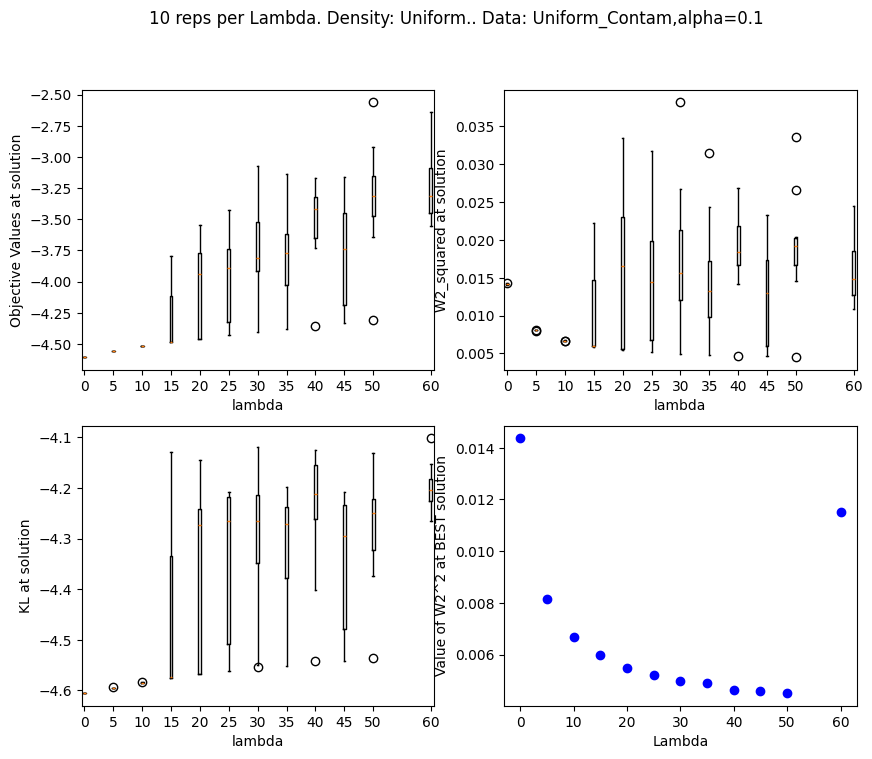

In [60]:
np.random.seed(1)
N = 100
alpha = .1
numWeightInit = 10
lambdas = [0,5,10,15,20,25,30,35,40,45,50,60]
finalPlt = doLambdaExp(N,alpha,numWeightInit,"unif",lambdas)

# Example 6: Running More Involved Experiments Using mass_update_repeated_runner

When you are running your own experiments, you may find the mass_update_repeated_runner function in mass_update to be helpful. It is what max_lambda_finder is using. Specifically, it will repeatedly generate new starting weights locations for a given set of $X$ lcoations and a source density and a given lambda, each time outputting the best weights, objective values for each run, $W_2^2$ for each run, and the KL costs for each run.

Here is an example of how to use it to conduct an experiment where we examine, for a set of data distributed uniformily on $[0,1]^2$ and the source density equal to the $Beta(\alpha,\alpha) \times Beta(\alpha,\alpha)$, what the optimal solutions look like in weight space, as well as in the location space, where we do 10 runs per $\lambda$.

runBetaExperiment sets up the simulation, using mass_repeated_runner for each value of $\lambda$.

In the plots in the left column, the final weights are plotted in increasing order for each run (there is low variability per run in these plots -- which is a good thing). In the right hand column, the masses of the best solution are mapped to the location of the points.

Also see the very last row, which shows the best solutions from each lambda. As lambda grows, we achieve lower entropy solutions -- which is what we expect, since the density is much more concentrated than the uniform.




In [61]:


#Z: how many data points?
#lams: The vector of lambas to consider
#conc: The single beta concentration to be used for the source density (which is a product of symmetric beta)
#freq: The number of splits per side on the histogramization of the source density
#numReps: The number of repetitions per lambda
def runBetaExperiment(Z,lams,con,freq,numReps):
    Y = np.column_stack((
        np.random.uniform(0,1,Z),
        np.random.uniform(0,1,Z)
    ))
    N = np.shape(Y)[0]
    density = ot.make_product_beta_density(con,con,con,con,freq)

    numReps = 10
    lams = [0,10,20,30,40,50,60]

    fig, axes = plt.subplots(len(lams)+1,2,figsize=(10,20))
    axLastA = axes[len(lams),0]
    axLastB = axes[len(lams),1]
    bestObjs = np.zeros(len(lams))

    k=0
    #obj = np.inf

    for lam in lams:
        print("Now working on lambda = "+str(lam))
        ax = axes[k,0]
        bestWeights,objVals,wassers,klCosts = mu.mass_update_repeated_runner(Y,numReps,np.ones(N),density,"absolute",.5,lam,traceCanvas=ax,upperLimOnTracePlot=.045)
        bestObjs[k] = min(wassers)

        ax = axes[k,1]
        sc = ax.scatter(Y[:,0],Y[:,1],c=bestWeights,cmap="viridis",vmin = 0,vmax = .043)
        fig.colorbar(sc,ax=ax,label="Mass")
        ax.set_title("Best Masses over the 10 optimizations")
        axLastA.plot(np.sort(bestWeights),alpha=0.3)

        k = k+1

    axLastA.set_title("Best masses over different Lambdas")
    axLastB.scatter(lams,bestObjs)
    axLastB.set_xlabel("lambda")
    axLastB.set_ylabel("Value of the W2^2 at best")

    plt.suptitle("Beta Product Density: Concentration = "+str(con)+". 1 Uniform Dataset. 10 Mass Inits." )
    plt.tight_layout()
    plt.show()

Now working on lambda = 0
Now working on lambda = 10
Now working on lambda = 20
Now working on lambda = 30
Now working on lambda = 40
Now working on lambda = 50
Now working on lambda = 60


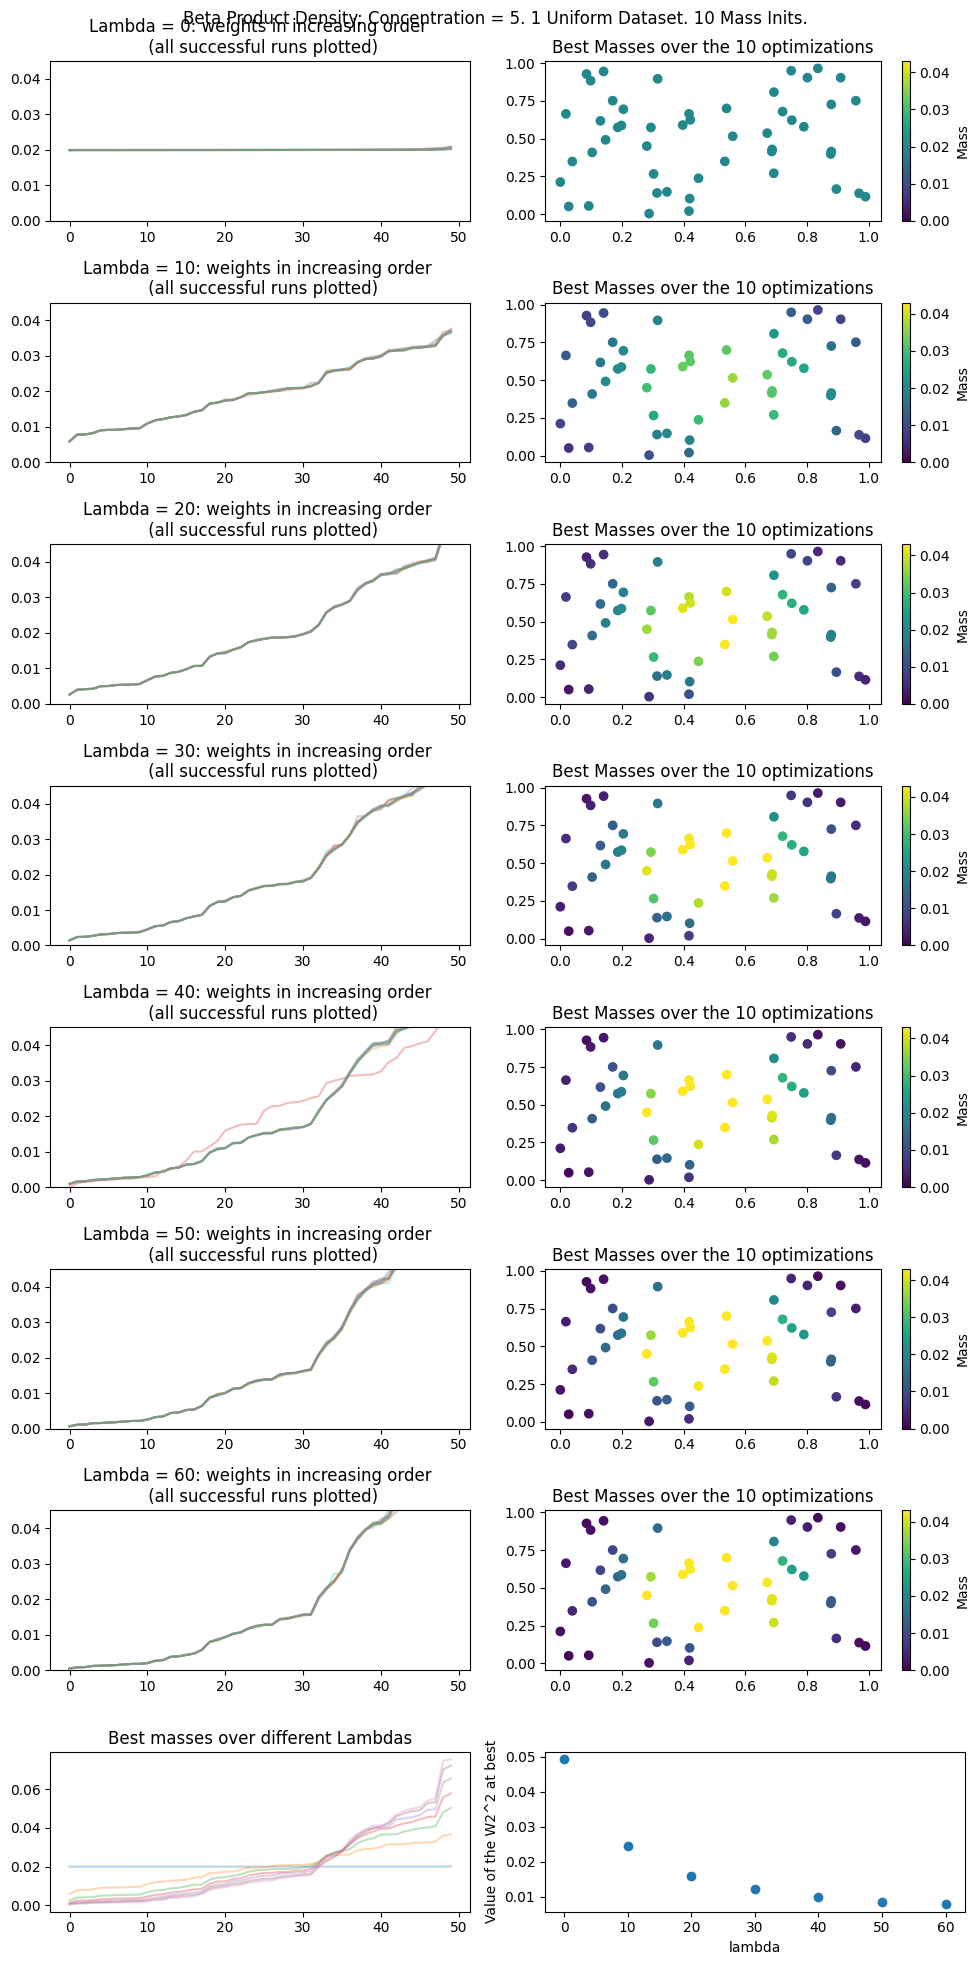

In [62]:
np.random.seed(1)
Z = 50
lams = [0,10,20,30,40,50,60]
con=5
freq = 20
numReps = 10
runBetaExperiment(Z,lams,con,freq,numReps)

# Example 7: Things can go wrong when the solution is close to the edges of the convex set

Recall that the $W_2^2$ optimization problem involves opimtizing a concave function on a convex set where the solution is in the convex set. What can go wrong? The convex set is the collection of potential vectors resulting in strictly positive integrals over the laguerre cells.

Consider a scenario where the best solution is to set some of the weights to nearly zero. This would happen if data points fall in the extremely low density regions of the source density.

In the below example, we gather uniform data, and optimize the weights with respect to a $Beta(conc,conc) \times Beta(conc,conc)$. In the $conc=5$ case everything is fine. For $conc = 100$, weight optimization cannot be completed.



In [63]:
#100 uniform data points
Z = 100
numReps = 1
Y = np.column_stack((
        np.random.uniform(0,1,Z),
        np.random.uniform(0,1,Z)
    ))
conc = 5
freq = 20
density = ot.make_product_beta_density(conc,conc,conc,conc,freq)
lam = 100

masses, g, weightOverWeightError,numIter,allWeightOverWeightErrors = mu.run_mass_update(Y,np.ones(Z)/Z,density,.5,lam)
ot.computeW2_squared(Y,masses,density,plotPowerDiagram=True)

<IPython.core.display.Javascript object>

np.float64(0.004414770023221833)

In [50]:
conc = 50
freq = 20
density = ot.make_product_beta_density(conc,conc,conc,conc,freq)
lam = 100

masses, g, weightOverWeightError,numIter,allWeightOverWeightErrors = mu.run_mass_update(Y,np.ones(Z)/Z,density,.5,lam)
ot.computeW2_squared(Y,masses,density,plotPowerDiagram=True)

/Users/peterjacobs/Desktop/gradSchool/postDoc/sdotProj/wcETEL/operational/optimal_transport_V2.py:498: MatrixRankWarning: Matrix is exactly singular
  d = spsolve(h, nup - g)


dgstrf info 1


ValueError: index pointer size (101) should be (3)

When $conc = 50$, the source density is extremely concentrated at $(1/2,1/2)$. So much so that the best weight vector might be attributing zero or very little mass to the outliers. In practice, this means that the likelihood is too close to zero for the caluclation to run properly. For the algorithm, the Hessian won't be invertible, and warnings about the ill conditioning of the Hessian will be thrown.